In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np


## Index
* [Part 1: Load and Inspect Data](#Load-and-Inspect-Data)
    * [Handle Age Outliers](#Handle-Age-Outliers)
    * [Inspect Country/Age/ distribution and their relationship with conversion rate](#Inspect-Country/Age-distribution-and-their-relationship-with-conversion-rate)
    * [Observations and Insights from Part 1](#Observations-and-Insights-from-Part-1)
* [Part 2: Data Preprocessing](#Data-Preprocessing)
    * [One-hot encoding for categorical features Country/Source](#OneHot-encoding-for-categorical-features-Country/Source)
    * [Observations and Insights from Part 2](#Observations-and-Insights-from-Part-2)

* [Part 3: Classify by using Random Forest](#Classify-via-Random-Forest)
    * [Train RF Model](#Train-RF-Model)
    * [Inspect Feature Importance](#Inspect-Feature-Importance)
    * [Inspect Train/Test AUC](#Inspect-Train/Test-AUC)
    * [Observations and Insights from Part 3](#Observations-and-Insights-from-Part-3)


## Part 1: Load and Inspect Data

In [64]:
missing_values = ["n/a", "na", "--"]
df = pd.read_csv("dataset/conversion_data.csv", na_values = missing_values)

In [65]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [66]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [67]:
df.size

1897200

In [68]:
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [69]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


The max of age is 123, which seems wrong.

### Handle Age Outliers

In [70]:
df.loc[df.age>=100,:]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [71]:
df = df.loc[df.age < 100,:]

### Inspect Country/Age/ distribution and their relationship with conversion rate

Delete data with age >= 100

Text(0.5, 1.0, 'converted distribution')

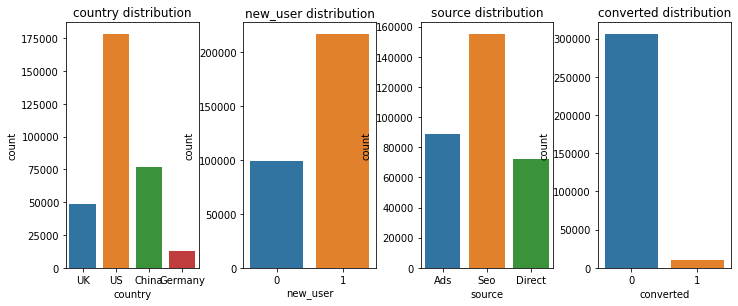

In [72]:
fig, axes =plt.subplots(1,4, figsize=(10,4))
plt.tight_layout()
sns.countplot(df['country'], ax=axes[0])
sns.countplot(df['new_user'], ax=axes[1])
sns.countplot(df["source"], ax=axes[2])
sns.countplot(df["converted"], ax=axes[3])
axes[0].set_title('country distribution')
axes[1].set_title('new_user distribution')
axes[2].set_title('source distribution')
axes[3].set_title("converted distribution")

Text(0.5, 1.0, 'source conversion')

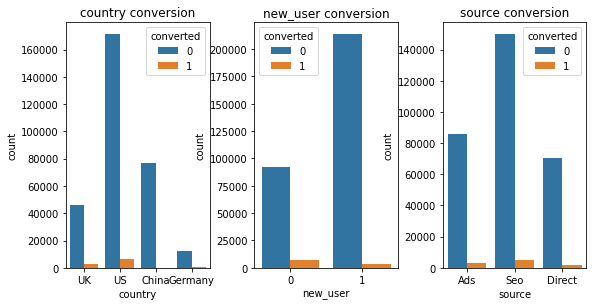

In [73]:
fig, axes =plt.subplots(1,3, figsize=(8,4))
plt.tight_layout()
sns.countplot(x='country', hue="converted", data=df, ax=axes[0])
sns.countplot(x='new_user', hue="converted", data=df, ax=axes[1])
sns.countplot(x='source', hue="converted", data=df, ax=axes[2])
axes[0].set_title('country conversion')
axes[1].set_title('new_user conversion')
axes[2].set_title('source conversion')

Text(0.5, 1.0, 'total_pages_visited conversion')

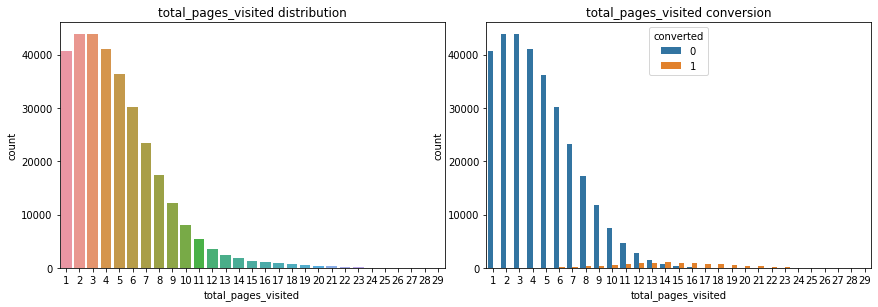

In [74]:
fig, axes =plt.subplots(1, 2, figsize=(12,4))
plt.tight_layout()
sns.countplot(x='total_pages_visited', data=df, ax=axes[0])
sns.countplot(x='total_pages_visited', hue="converted", data=df, ax=axes[1])
axes[0].set_title('total_pages_visited distribution')
axes[1].set_title('total_pages_visited conversion')

Text(0.5, 1.0, 'age conversion')

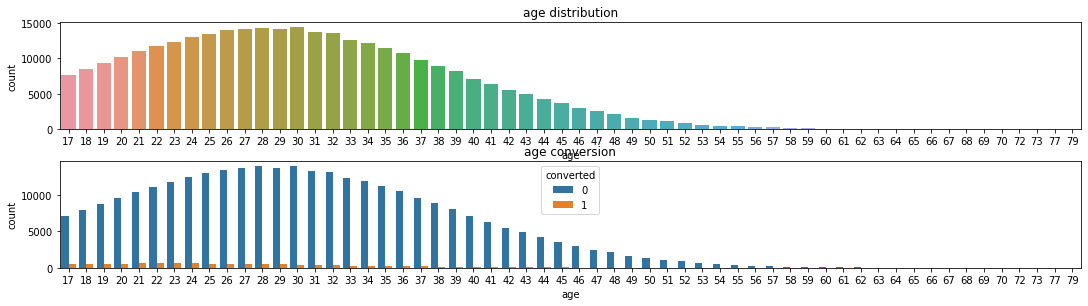

In [75]:
fig, axes =plt.subplots(2, 1, figsize=(15,4))
plt.tight_layout()
sns.countplot(x='age', data=df, ax=axes[0])
sns.countplot(x='age', hue="converted", data=df, ax=axes[1])
axes[0].set_title('age distribution')
axes[1].set_title('age conversion')

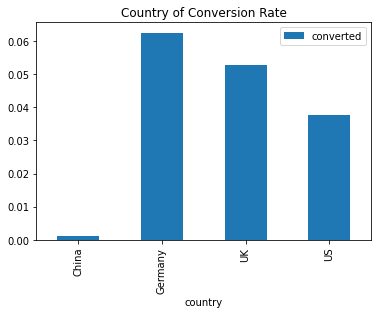

In [76]:
df[['country', 'converted']].groupby('country').mean().plot.bar(title="Country of Conversion Rate")

China has the lowest conversion rate.

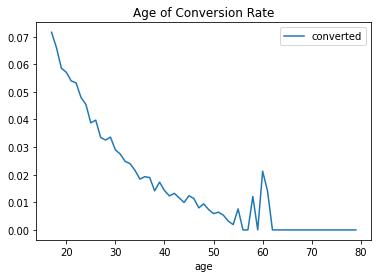

In [77]:
df[['age', 'converted']].groupby('age').mean().plot(title="Age of Conversion Rate")

The conversion rate drops as users' age increases.

### Observations and Insights from Part 1
1. The data is **imbalanced**, and data with unconverted label are much more than data with converted label, so we need to take this into consideration when training machine learning models.
2. The **majority** of users are **from US, new_user, and from seo source**.
3. US, UK, and Germany have converted users, however, **China seems with no conversion** at all. So next, if we want to grow the market, one way is to find out why some country like China has critical low conversion rate.
4. The conversion rate for **new_user is much lower** than that of old_users.
5. In terms of different sources, a majority of users come from seo, even the converated number of users from seo is greater than that from other two sources, but **the conversion rate of seo seems low** than that from ads sources. Need more investigation.
6. The total_pages_visited seems to follow the normal distribution, most people visited less than 8 pages, however, when a user visited more than 8 pages, the conversion rate gets much higher for these users. So we need to think about strageties to **attact users to visit more pages**.
7. Most users are from age 17 - 40, but **the conversion rate of young users aged from 17-30 is higher**. 

## Part 2: Data Preprocessing
For other models, they may require StandardScaler for numerical features "age" & "total_pages_visited". But for RF, this step is not necessary.

### One-hot encoding for categorical features Country/Source

Finally, merge all the features in the order of new_users, age, total_pages_visited, country, and source.

In [78]:
# One-hot encode categorical features
dfc = pd.get_dummies(df)
dfc.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


## Part 3: Train Model with Logistic Regression and Random Forest

I chose Random Forest(RF) model for two reasons. The first one is that RF can have a good performance for default parameters. Also, it can generate feature importances that could be useful to identify insights.
Pay attention for imbalanced data.

### Train RF Model

In [82]:
%%time
from sklearn.ensemble import RandomForestClassifier
#X = dfc.loc[:, (dfc.columns != 'converted') & (dfc.columns != "total_pages_visited")]
X = dfc.loc[:, dfc.columns != 'converted']
y = dfc['converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# RF - model class_weight="balanced"
clf = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=100, class_weight="balanced")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
classes = [str(c) for c in clf.classes_]
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     91828
           1       0.33      0.93      0.49      3032

    accuracy                           0.94     94860
   macro avg       0.67      0.93      0.73     94860
weighted avg       0.98      0.94      0.95     94860

CPU times: user 6.55 s, sys: 500 ms, total: 7.05 s
Wall time: 7.1 s


### Inspect Feature Importance

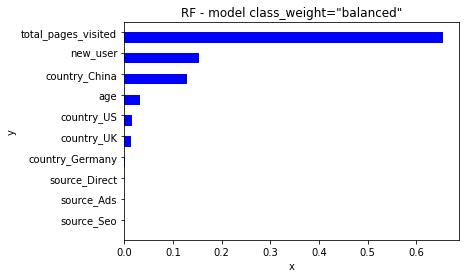

In [83]:
def plot_rf_feature_importance(features, importance, title):
    feature_importance = {}
    for i in range(0, len(features)):
        feature_importance[features[i]] = importance[i]
    feature_importance = sorted(feature_importance.items(), key=lambda item:item[1])
    
    x = [f[0] for f in feature_importance]
    y = [f[1] for f in feature_importance]
    fig, ax = plt.subplots()    
    width = 0.5               # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')     
    plt.show()

features = list(X.columns)
importance = clf.feature_importances_.tolist()
plot_rf_feature_importance(features, importance, "RF - model class_weight=\"balanced\"")

### Inspect Train/Test AUC

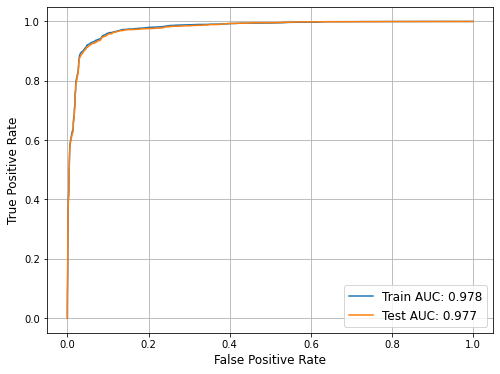

In [84]:
from sklearn.metrics import auc, roc_curve
X_train, X_test, y_train, y_test

train_true = y_train
train_pred = clf.predict_proba(X_train)

test_true = y_test
test_pred = clf.predict_proba(X_test)

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred[:,1])
test_fpr, test_tpr, _ = roc_curve(np.array(test_true), test_pred[:,1])
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_fpr, train_tpr, label="Train AUC: " + str(train_auc))
ax.plot(test_fpr, test_tpr, label="Test AUC: " + str(test_auc))
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.legend(fontsize=12)
plt.grid()
plt.show()

Train AUC and Test AUC do not have an obvious difference, so we could conclude that the RF model do not overfit.

### Observations and Insights from Part 3
1. After balancing the dataset, the overall prediction accuracy and f1_score can be as high as **94%** for Logistic Regression model, and **93%** for Random Forest model.
2. The top important features are **total_pages_visited**, **new_user**, **country_China**, and **age**.
3. Users are **more likely to be converted if they visited more pages**, so we could think of some way to encourage them to view more pages, such as treasure collecting activities in different pages, give them some bonus after they finish visiting some pages, or design more related pages.
4. new_users are less likely to be converted, so we need to think about **recall old users** back to visit pages again, for example, we could provide recall promotion coupons for them.
5. **China** seems with lower conversion rate, so we could think about why less people in this country are less willing to be converted.
6. **Young people aged between 17-30 are more likely to be converted**. On the one hand, we could continue to provide strategies and products that attract this group of people. On the other hand, we could think of some strategies to attract people from other age groups, or provide more products for them.
